Key parameters for Finnish health districts

The aim of this work is to

1. Creating a GIS layer for Finnish Health Districts
2. Illustrating proportion of population over 65 years and average income in every district for people older than 18.

Finnish municipalities with health district information is an Excel spreadsheet from Kuntaliitto: https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat File Shp_jäsenkunnat_2020.xls, sheet kunnat_shp_2020_ aakkosjärj.

"shp" stands for "sairaanhoitopiiri" (health district in Finnish). I have changed the name of the file to Shp_jasenkunnat_2020.xls and sheet to kunnat_shp_2020_ aakkosjarj

Municipality polygons from Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html wfs: http://geo.stat.fi/geoserver/tilastointialueet/wfs? feature: tilastointialueet:kunta1000k (most recent information about municipality polygons).

Population count for each municipality from Statistics Finland: https://www.stat.fi/org/avoindata/paikkatietoaineistot/vaesto_tilastointialueittain.html

Average income from the Paavo (zip-code) database: https://www.stat.fi/org/avoindata/paikkatietoaineistot.html 



In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import xlrd   #to be able to read Excel

In [2]:
#check if you have up to date version of pandas, problem can occur when loading geopandas
pd.show_versions(as_json=False)


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.8.2.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
machine          : AMD64
processor        : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : Finnish_Finland.1252

pandas           : 1.0.3
numpy            : 1.18.4
pytz             : 2020.1
dateutil         : 2.8.1
pip              : 20.1
setuptools       : 46.1.3.post20200325
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.13.0
pandas_datareader: None
bs4              : None
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : Non

In [3]:
#1. Health district data

df_orig = pd.read_excel("Shp_jasenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjarj",
                     header=3)
df_orig.dropna(inplace=True)
df_orig.head()

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0
5,16.0,Asikkala,7.0,Päijät-Häme,HYKS,5.0


In [4]:
healthDistrict = df_orig.copy()
print(healthDistrict.shape)
healthDistrict.tail()

(294, 6)


,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
290,977.0,Ylivieska,18.0,Pohjois-Pohjanmaa,OYS,290.0
291,980.0,Ylöjärvi,6.0,Pirkanmaa,TAYS,291.0
292,981.0,Ypäjä,5.0,Kanta-Häme,TAYS,292.0
293,989.0,Ähtäri,15.0,Etelä-Pohjanmaa,TAYS,293.0
294,992.0,Äänekoski,14.0,Keski-Suomi,KYS,294.0


In [5]:
healthDistrict.rename(columns={"kunta-\nkoodi":"code", 'sairaanhoitopiiri':'healthCareDistrict'},
          inplace=True)
healthDistrict = healthDistrict[['code','healthCareDistrict']]
healthDistrict.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 294 entries, 1 to 294
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   code                294 non-null    float64
 1   healthCareDistrict  294 non-null    object 
dtypes: float64(1), object(1)
memory usage: 6.9+ KB


In [6]:
# Truncate and convert to character string
healthDistrict["code"] = healthDistrict["code"].astype(int)
healthDistrict["code"] = healthDistrict["code"].astype('str')
healthDistrict.head()


,code,healthCareDistrict
1,20,Pirkanmaa
2,5,Etelä-Pohjanmaa
3,9,Pohjois-Pohjanmaa
4,10,Etelä-Pohjanmaa
5,16,Päijät-Häme


In [7]:
# Add missing zeros to municipality codes
healthDistrict["code"] = healthDistrict["code"].apply(lambda x: "00" + x if len(x)==1 else x)
healthDistrict["code"] = healthDistrict["code"].apply(lambda x: "0" + x if len(x)==2 else x)
healthDistrict.tail()


,code,healthCareDistrict
290,977,Pohjois-Pohjanmaa
291,980,Pirkanmaa
292,981,Kanta-Häme
293,989,Etelä-Pohjanmaa
294,992,Keski-Suomi


In [8]:
healthDistrict.head()

,code,healthCareDistrict
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


In [9]:
healthDistrict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294 entries, 1 to 294
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   code                294 non-null    object
 1   healthCareDistrict  294 non-null    object
dtypes: object(2)
memory usage: 6.9+ KB


Municipality polygons from Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html wfs: http://geo.stat.fi/geoserver/tilastointialueet/wfs? feature: tilastointialueet:kunta1000k (most recent information about municipality polygons)


In [10]:
#2. GIS layer data

# For available features, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON"
geodata_orig = gpd.read_file(url)

In [11]:
# There are 310 municipalities in Finland in 2020
geodata = geodata_orig.copy()
print(geodata.shape)
geodata.head()

(310, 7)


,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k.1,005,2020,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,kunta1000k.2,009,2020,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,kunta1000k.3,010,2020,Alavus,Alavus,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,kunta1000k.4,016,2020,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,kunta1000k.5,018,2020,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


In [12]:
#Select and rename columns
geodata = geodata[['kunta', 'geometry']]
geodata.rename(columns={'kunta':'code'}, inplace=True)
geodata.tail()

,code,geometry
305,977,"POLYGON ((398010.991 7110887.267, 399696.069 7..."
306,980,"POLYGON ((313738.511 6896936.100, 319421.316 6..."
307,981,"POLYGON ((297451.456 6756204.328, 297931.884 6..."
308,989,"POLYGON ((348733.187 6959704.551, 349457.337 6..."
309,992,"POLYGON ((452626.858 6973610.366, 457542.012 6..."


In [13]:
geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   code      310 non-null    object  
 1   geometry  310 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 5.0+ KB


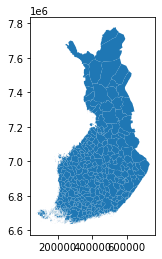

In [14]:
#Plot of municipalities
geodata.plot()

Population count for each municipality from Statistics Finland: https://www.stat.fi/org/avoindata/paikkatietoaineistot/vaesto_tilastointialueittain.html

WFS: http://geo.stat.fi/geoserver/vaestoalue/wfs 
Note: Valtimo merged with Nurmes in 2020. Belongs to Pohjois-Karjala health care district. 

In [15]:
# For available features, see http://geo.stat.fi/geoserver/vaestoalue/
#wfs?request=GetCapabilities

url = "http://geo.stat.fi/geoserver/vaestoalue/wfs?request=GetFeature&typename=vaestoalue:kunta_vaki2018&outputformat=JSON"
pop_orig = gpd.read_file(url)

In [16]:
pop = pop_orig.copy()
print(pop.shape)
print(list(pop))
pop.head()

(311, 20)
['id', 'kunta', 'vuosi', 'nimi', 'namn', 'name', 'til_vuosi', 'vaesto', 'vaesto_p', 'miehet', 'miehet_p', 'naiset', 'naiset_p', 'ika_0_14', 'ika_0_14p', 'ika_15_64', 'ika_15_64p', 'ika_65_', 'ika_65_p', 'geometry']


,id,kunta,vuosi,nimi,namn,name,til_vuosi,vaesto,vaesto_p,miehet,miehet_p,naiset,naiset_p,ika_0_14,ika_0_14p,ika_15_64,ika_15_64p,ika_65_,ika_65_p,geometry
0,kunta_vaki2018.1,005,2019,Alajärvi,Alajärvi,Alajärvi,2018,9700,0.2,4905,50.6,4795,49.4,1688,17.4,5374,55.4,2638,27.2,"MULTIPOLYGON (((348733.187 6959704.551, 343298..."
1,kunta_vaki2018.2,009,2019,Alavieska,Alavieska,Alavieska,2018,2573,0.0,1351,52.5,1222,47.5,498,19.4,1466,57.0,609,23.7,"MULTIPOLYGON (((370424.741 7104339.037, 360962..."
2,kunta_vaki2018.3,010,2019,Alavus,Alavus,Alavus,2018,11544,0.2,5821,50.4,5723,49.6,1961,17.0,6472,56.1,3111,26.9,"MULTIPOLYGON (((317245.323 6922242.407, 310933..."
3,kunta_vaki2018.4,016,2019,Asikkala,Asikkala,Asikkala,2018,8149,0.1,4071,50.0,4078,50.0,1154,14.2,4368,53.6,2627,32.2,"MULTIPOLYGON (((434407.880 6774122.311, 422536..."
4,kunta_vaki2018.5,018,2019,Askola,Askola,Askola,2018,4958,0.1,2519,50.8,2439,49.2,995,20.1,3018,60.9,945,19.1,"MULTIPOLYGON (((423421.791 6704555.878, 420729..."


In [17]:
#Select and rename columns
pop = pop[["kunta", "name", "vaesto","ika_65_", "geometry"]]
pop.rename(columns={'kunta':'code', 'vaesto':'population', 'ika_65_':'age_65'}, inplace=True)
pop.tail()

,code,name,population,age_65,geometry
306,977,Ylivieska,15212,2924,"MULTIPOLYGON (((384323.357 7093223.300, 368395..."
307,980,Ylöjärvi,32983,5799,"MULTIPOLYGON (((321683.421 6826506.299, 316192..."
308,981,Ypäjä,2357,658,"MULTIPOLYGON (((296901.865 6736363.869, 290626..."
309,989,Ähtäri,5703,1776,"MULTIPOLYGON (((345455.367 6918226.112, 341008..."
310,992,Äänekoski,18851,4966,"MULTIPOLYGON (((432762.406 6929615.249, 429393..."


In [18]:
# Check length, in 2020, there are 310 Municipalities. 
# 2019 data still contains Valtimo which was merged with Nurmes at the end of 2019
pop.loc[pop['name'] == 'Valtimo']

,code,name,population,age_65,geometry
292,911,Valtimo,2143,757,"MULTIPOLYGON (((582880.682 7049200.219, 579773..."


In [19]:
pop.loc[pop['name'] == 'Nurmes']

,code,name,population,age_65,geometry
176,541,Nurmes,7641,2581,"MULTIPOLYGON (((623462.217 7026722.969, 616616..."


In [20]:
pop.loc[292, 'name'] = 'Nurmes'
pop.loc[292, 'code'] = 541

temp = pop.loc[pop['name'] == 'Nurmes']
temp

,code,name,population,age_65,geometry
176,541,Nurmes,7641,2581,"MULTIPOLYGON (((623462.217 7026722.969, 616616..."
292,541,Nurmes,2143,757,"MULTIPOLYGON (((582880.682 7049200.219, 579773..."


In [21]:
# Re-join municipality names to the new geometries. 
temp = temp.dissolve(by="name", aggfunc = 'sum')
temp.reset_index(inplace=True)  
temp

,name,geometry,population,age_65
0,Nurmes,"POLYGON ((623462.217 7026722.969, 616616.715 7...",9784,3338


In [22]:
#temp.loc[0, 'geometry']  #Nurmes and Valtimo

In [23]:
#pop.loc[292, 'geometry']  #Valtimo

In [24]:
#pop.loc[176, 'geometry']  #"old" Nurmes

In [25]:
pop.loc[176, 'geometry'] = temp.loc[0, 'geometry']
pop.loc[176, 'population'] = temp.loc[0, 'population']
pop.loc[176, 'age_65'] = temp.loc[0, 'age_65']
#drop Valtimo
pop = pop.drop(292)
print(pop.shape)
pop.loc[176]

(310, 5)


code                                                        541
name                                                     Nurmes
population                                                 9784
age_65                                                     3338
geometry      POLYGON ((623462.2167 7026722.96900001, 616616...
Name: 176, dtype: object

In [26]:
pop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 310 entries, 0 to 310
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   code        310 non-null    object  
 1   name        310 non-null    object  
 2   population  310 non-null    int64   
 3   age_65      310 non-null    int64   
 4   geometry    310 non-null    geometry
dtypes: geometry(1), int64(2), object(2)
memory usage: 24.5+ KB


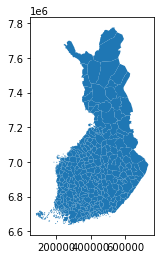

In [27]:
#The population data comes also with municipality polygons.
pop.plot()

In [28]:
#However, I will return to using the 1000k more precise polygons read in earlier

geodata = geodata.merge(pop[["code", "name", "population", "age_65"]], on="code")
geodata.head()

,code,geometry,name,population,age_65
0,005,"POLYGON ((366787.924 7001300.583, 364487.590 6...",Alajärvi,9700,2638
1,009,"POLYGON ((382543.364 7120022.976, 382899.505 7...",Alavieska,2573,609
2,010,"POLYGON ((343298.204 6961570.195, 343831.847 6...",Alavus,11544,3111
3,016,"POLYGON ((436139.680 6798279.085, 435714.468 6...",Asikkala,8149,2627
4,018,"POLYGON ((426631.036 6720528.076, 428821.749 6...",Askola,4958,945


In [29]:
#Join Health district to geodata
geodata = geodata.merge(healthDistrict, on="code", how="left")
geodata.tail(8)

,code,geometry,name,population,age_65,healthCareDistrict
302,941,"MULTIPOLYGON (((130962.734 6681775.043, 130880...",Vårdö,448,141,NaN
303,946,"MULTIPOLYGON (((258629.304 7024672.876, 258721...",Vöyri,6613,1676,Vaasa
304,976,"POLYGON ((411402.469 7405428.684, 411736.599 7...",Ylitornio,4022,1465,Länsi-Pohja
305,977,"POLYGON ((398010.991 7110887.267, 399696.069 7...",Ylivieska,15212,2924,Pohjois-Pohjanmaa
306,980,"POLYGON ((313738.511 6896936.100, 319421.316 6...",Ylöjärvi,32983,5799,Pirkanmaa
307,981,"POLYGON ((297451.456 6756204.328, 297931.884 6...",Ypäjä,2357,658,Kanta-Häme
308,989,"POLYGON ((348733.187 6959704.551, 349457.337 6...",Ähtäri,5703,1776,Etelä-Pohjanmaa
309,992,"POLYGON ((452626.858 6973610.366, 457542.012 6...",Äänekoski,18851,4966,Keski-Suomi


In [30]:
# Municipalities in the Åland island did not have a matching health care district in the data
# count the number of NaN values in each column
print(geodata.isnull().sum())
geodata[geodata.healthCareDistrict.isnull()].name

code                   0
geometry               0
name                   0
population             0
age_65                 0
healthCareDistrict    16
dtype: int64


7          Brändö
8          Eckerö
15       Finström
17          Föglö
18           Geta
24     Hammarland
58         Jomala
112      Kumlinge
122         Kökar
135       Lemland
148    Lumparland
154     Mariehamn
237       Saltvik
255      Sottunga
257          Sund
302         Vårdö
Name: name, dtype: object

In [31]:
# Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)
geodata.loc[geodata.healthCareDistrict.isnull(),'healthCareDistrict'] = "Ahvenanmaa"
geodata.healthCareDistrict.value_counts()

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Etelä-Pohjanmaa      18
Pohjois-Savo         18
Satakunta            17
Ahvenanmaa           16
Lappi                15
Pohjois-Karjala      13
Vaasa                13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Savo            9
Etelä-Karjala         9
Kainuu                8
Länsi-Pohja           6
Kymenlaakso           6
Itä-Savo              4
Name: healthCareDistrict, dtype: int64

In [32]:
geodata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 310 entries, 0 to 309
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   code                310 non-null    object  
 1   geometry            310 non-null    geometry
 2   name                310 non-null    object  
 3   population          310 non-null    int64   
 4   age_65              310 non-null    int64   
 5   healthCareDistrict  310 non-null    object  
dtypes: geometry(1), int64(2), object(3)
memory usage: 17.0+ KB


In [33]:
#Create polygons for health care districts
# Dissolve (=combine) municipality polygon geometries for each health care district
#https://geopandas.org/aggregation_with_dissolve.html
# In the geopandas library, we can aggregate geometric features using the dissolve function.

districts = geodata.dissolve(by='healthCareDistrict', aggfunc="sum")
districts.reset_index(inplace=True)
districts.head(3)

,healthCareDistrict,geometry,population,age_65
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789,6620
1,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756,34467
2,Etelä-Pohjanmaa,"POLYGON ((249539.259 6894974.367, 244232.829 6...",194316,48069


In [34]:
#calclulate percentage old
districts['perc_pop_over_65'] = round( (districts['age_65']/districts['population']*100) , 1)
districts

,healthCareDistrict,geometry,population,age_65,perc_pop_over_65
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789,6620,22.2
1,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756,34467,26.8
2,Etelä-Pohjanmaa,"POLYGON ((249539.259 6894974.367, 244232.829 6...",194316,48069,24.7
3,Etelä-Savo,"POLYGON ((596327.952 6823806.064, 596718.363 6...",100226,29189,29.1
4,HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418...",1667203,289183,17.3
5,Itä-Savo,"POLYGON ((572240.425 6898837.522, 576521.513 6...",41060,13063,31.8
6,Kainuu,"POLYGON ((606127.874 7081796.115, 603849.594 7...",73061,20078,27.5
7,Kanta-Häme,"POLYGON ((393094.362 6756355.691, 394102.316 6...",171364,42238,24.6
8,Keski-Pohjanmaa,"MULTIPOLYGON (((302835.219 7083897.220, 302801...",77689,17951,23.1
9,Keski-Suomi,"POLYGON ((439110.805 6852598.036, 439300.113 6...",252676,55624,22.0


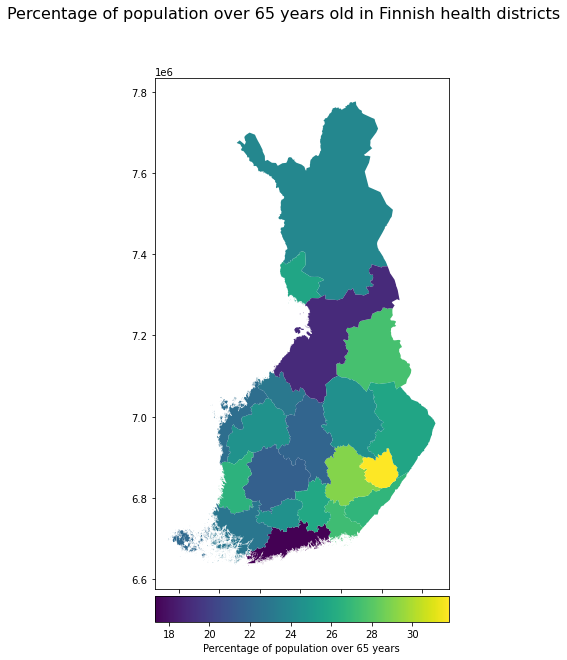

In [35]:
# Plot population estimates with an accurate legend, https://geopandas.org/mapping.html
#hover, name and population!
import mplcursors
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(20, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)   
fig.suptitle('Percentage of population over 65 years old in Finnish health districts', fontsize=16)

districts.plot( column='perc_pop_over_65', ax=ax, cax = cax, legend=True, legend_kwds=
               {'label': "Percentage of population over 65 years", 'orientation': "horizontal"} ) 

In [36]:
#3. Calculate average income

#Paavo: https://www.stat.fi/org/avoindata/paikkatietoaineistot.html, zip-code info for Finland

url = "http://geo.stat.fi/geoserver/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=postialue:pno_tilasto&outputFormat=json"
zip_code_orig = gpd.read_file(url)
zip_code_orig.tail()

,id,postinumeroalue,nimi,namn,euref_x,euref_y,pinta_ala,vuosi,kunta,he_vakiy,...,tp_u_kans,tp_x_tunt,pt_vakiy,pt_tyoll,pt_tyott,pt_0_14,pt_opisk,pt_elakel,pt_muut,geometry
3021,pno_tilasto.3013,99750,Sassali,Sassali,449527,7460019,82448873,2020,758,52,...,-1,-1,55,23,7,7,1,16,1,"MULTIPOLYGON (((454623.289 7453821.316, 456232..."
3022,pno_tilasto.3014,99760,Uimaniemi,Uimaniemi,444678,7455448,36648366,2020,758,29,...,0,0,27,-1,-1,-1,-1,-1,-1,"MULTIPOLYGON (((443619.996 7450597.622, 446010..."
3023,pno_tilasto.3016,99800,Ivalo,Ivalo,512683,7625472,7076623988,2020,148,4593,...,0,0,4549,1979,235,584,225,1429,97,"MULTIPOLYGON (((542284.894 7631083.951, 541735..."
3024,pno_tilasto.3017,99830,Saariselkä,Saariselkä,517244,7586650,519123785,2020,148,357,...,0,0,367,248,13,39,8,55,4,"MULTIPOLYGON (((520107.707 7580422.155, 522461..."
3025,pno_tilasto.1633,56800,Simpele,Simpele,621298,6815906,171455718,2020,689,2320,...,0,0,2390,712,175,249,127,1086,41,"MULTIPOLYGON (((621420.412 6822621.083, 621291..."


In [37]:
df = zip_code_orig.copy()
print(df.shape)
print(list(df))

(3026, 111)
['id', 'postinumeroalue', 'nimi', 'namn', 'euref_x', 'euref_y', 'pinta_ala', 'vuosi', 'kunta', 'he_vakiy', 'he_naiset', 'he_miehet', 'he_kika', 'he_0_2', 'he_3_6', 'he_7_12', 'he_13_15', 'he_16_17', 'he_18_19', 'he_20_24', 'he_25_29', 'he_30_34', 'he_35_39', 'he_40_44', 'he_45_49', 'he_50_54', 'he_55_59', 'he_60_64', 'he_65_69', 'he_70_74', 'he_75_79', 'he_80_84', 'he_85_', 'ko_ika18y', 'ko_perus', 'ko_koul', 'ko_yliop', 'ko_ammat', 'ko_al_kork', 'ko_yl_kork', 'hr_tuy', 'hr_ktu', 'hr_mtu', 'hr_pi_tul', 'hr_ke_tul', 'hr_hy_tul', 'hr_ovy', 'te_taly', 'te_takk', 'te_as_valj', 'te_nuor', 'te_eil_np', 'te_laps', 'te_plap', 'te_aklap', 'te_klap', 'te_teini', 'te_aik', 'te_elak', 'te_omis_as', 'te_vuok_as', 'te_muu_as', 'tr_kuty', 'tr_ktu', 'tr_mtu', 'tr_pi_tul', 'tr_ke_tul', 'tr_hy_tul', 'tr_ovy', 'ra_ke', 'ra_raky', 'ra_muut', 'ra_asrak', 'ra_asunn', 'ra_as_kpa', 'ra_pt_as', 'ra_kt_as', 'tp_tyopy', 'tp_alku_a', 'tp_jalo_bf', 'tp_palv_gu', 'tp_a_maat', 'tp_b_kaiv', 'tp_c_teol', '

In [38]:
#'hr_ktu' is average yearly income(€) for inhabitants over 18 years in 2017.   
#'ko_ika18y' is the number of inhabitants of age 18 or over (2018)

df = df[['postinumeroalue', 'kunta', 'ko_ika18y', 'hr_ktu']]

#kunta is municipality, replaced with code
df.rename(columns={'postinumeroalue': 'zip_code', 'kunta': 'code', 'ko_ika18y':'age18', 
                   'hr_ktu':'average_income'}, inplace = True)

df['total_av_income'] = df['average_income']* df['age18'] 
df['total_av_income'] = df['total_av_income'].astype(int)
df.head()

,zip_code,code,age18,average_income,total_av_income
0,00250,091,10047,30448,305911056
1,00260,091,4925,36039,177492075
2,00270,091,6607,28463,188055041
3,00280,091,2603,27141,70648023
4,00290,091,132,39325,5190900


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026 entries, 0 to 3025
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   zip_code         3026 non-null   object
 1   code             3026 non-null   object
 2   age18            3026 non-null   int64 
 3   average_income   3026 non-null   int64 
 4   total_av_income  3026 non-null   int32 
dtypes: int32(1), int64(2), object(2)
memory usage: 106.5+ KB


In [40]:
# count the number of NaN values in each column
print(df.isnull().sum())

zip_code           0
code               0
age18              0
average_income     0
total_av_income    0
dtype: int64


In [41]:
#Assuming if avaraeg income less than 1 €/ year, data is missing and rows are dropped.
temp = df.loc[df['average_income'] <= 1]
temp

,zip_code,code,age18,average_income,total_av_income
88,01770,092,0,0,0
139,21680,445,8,-1,-8
181,05850,106,0,0,0
250,08360,444,1,0,0
293,13530,109,2,-1,-2
...,...,...,...,...,...
2988,97950,614,14,-1,-14
2994,97999,261,0,0,0
3001,99520,758,27,-1,-27
3017,99695,758,2,-1,-2


In [42]:
#drop temp index number
drop_list = temp.index.to_list()
df = df.drop(drop_list)
print(df.shape)
df.tail(10)

(2942, 5)


,zip_code,code,age18,average_income,total_av_income
3014,99660,758,41,21952,900032
3015,99665,758,33,26033,859089
3016,99690,758,224,19960,4471040
3018,99710,758,241,21615,5209215
3019,99720,758,148,19870,2940760
3020,99740,758,138,20301,2801538
3021,99750,758,45,17952,807840
3023,99800,148,3876,23062,89388312
3024,99830,148,312,25107,7833384
3025,56800,689,2032,20790,42245280


In [43]:
#df = df [['code', 'total_income']]
df = df [['code', 'age18', 'total_av_income']]
df = df.groupby(['code']).sum()
df.reset_index(inplace=True)  
print(df.shape)
df.head()

(310, 3)


,code,age18,total_av_income
0,005,7549,158698859.0
1,009,1938,41553569.0
2,010,9147,193361810.0
3,016,6666,153955847.0
4,018,3706,102606962.0


In [44]:
#292= Valtimo is correctly missing
print(df['code'].to_list())

['005', '009', '010', '016', '018', '019', '020', '035', '043', '046', '047', '049', '050', '051', '052', '060', '061', '062', '065', '069', '071', '072', '074', '075', '076', '077', '078', '079', '081', '082', '086', '090', '091', '092', '097', '098', '099', '102', '103', '105', '106', '108', '109', '111', '139', '140', '142', '143', '145', '146', '148', '149', '151', '152', '153', '165', '167', '169', '170', '171', '172', '176', '177', '178', '179', '181', '182', '186', '202', '204', '205', '208', '211', '213', '214', '216', '217', '218', '224', '226', '230', '231', '232', '233', '235', '236', '239', '240', '241', '244', '245', '249', '250', '256', '257', '260', '261', '263', '265', '271', '272', '273', '275', '276', '280', '284', '285', '286', '287', '288', '290', '291', '295', '297', '300', '301', '304', '305', '309', '312', '316', '317', '318', '320', '322', '398', '399', '400', '402', '403', '405', '407', '408', '410', '416', '417', '418', '420', '421', '422', '423', '425', '426'

In [45]:
#Join Total Average Income to geodata
geo_df = geodata.merge(df, on="code", how="left")
print(list(geo_df))
geo_df.tail(8)

['code', 'geometry', 'name', 'population', 'age_65', 'healthCareDistrict', 'age18', 'total_av_income']


,code,geometry,name,population,age_65,healthCareDistrict,age18,total_av_income
302,941,"MULTIPOLYGON (((130962.734 6681775.043, 130880...",Vårdö,448,141,Ahvenanmaa,339,8586870.0
303,946,"MULTIPOLYGON (((258629.304 7024672.876, 258721...",Vöyri,6613,1676,Vaasa,5148,119923557.0
304,976,"POLYGON ((411402.469 7405428.684, 411736.599 7...",Ylitornio,4022,1465,Länsi-Pohja,3452,73876819.0
305,977,"POLYGON ((398010.991 7110887.267, 399696.069 7...",Ylivieska,15212,2924,Pohjois-Pohjanmaa,11353,263227189.0
306,980,"POLYGON ((313738.511 6896936.100, 319421.316 6...",Ylöjärvi,32983,5799,Pirkanmaa,23192,591570687.0
307,981,"POLYGON ((297451.456 6756204.328, 297931.884 6...",Ypäjä,2357,658,Kanta-Häme,1903,40903436.0
308,989,"POLYGON ((348733.187 6959704.551, 349457.337 6...",Ähtäri,5703,1776,Etelä-Pohjanmaa,4726,100590457.0
309,992,"POLYGON ((452626.858 6973610.366, 457542.012 6...",Äänekoski,18851,4966,Keski-Suomi,15074,335902423.0


In [46]:
districts2 = geo_df.dissolve(by='healthCareDistrict', aggfunc="sum")
districts2['income_pro_person'] = round( districts2['total_av_income']/districts2['age18'] , 0)
districts2['income_pro_person'] = districts2['income_pro_person'].astype(int)
districts2.reset_index(inplace=True)
districts2

,healthCareDistrict,geometry,population,age_65,age18,total_av_income,income_pro_person
0,Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789,6620,23478,6.573709e+08,27999
1,Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756,34467,106495,2.379502e+09,22344
2,Etelä-Pohjanmaa,"POLYGON ((249539.259 6894974.367, 244232.829 6...",194316,48069,154847,3.488426e+09,22528
3,Etelä-Savo,"POLYGON ((596327.952 6823806.064, 596718.363 6...",100226,29189,85514,1.880360e+09,21989
4,HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418...",1667203,289183,1312192,3.719024e+10,28342
5,Itä-Savo,"POLYGON ((572240.425 6898837.522, 576521.513 6...",41060,13063,34381,7.181452e+08,20888
6,Kainuu,"POLYGON ((606127.874 7081796.115, 603849.594 7...",73061,20078,59921,1.291564e+09,21554
7,Kanta-Häme,"POLYGON ((393094.362 6756355.691, 394102.316 6...",171364,42238,137125,3.245795e+09,23670
8,Keski-Pohjanmaa,"MULTIPOLYGON (((302835.219 7083897.220, 302801...",77689,17951,59882,1.355775e+09,22641
9,Keski-Suomi,"POLYGON ((439110.805 6852598.036, 439300.113 6...",252676,55624,201329,4.550443e+09,22602


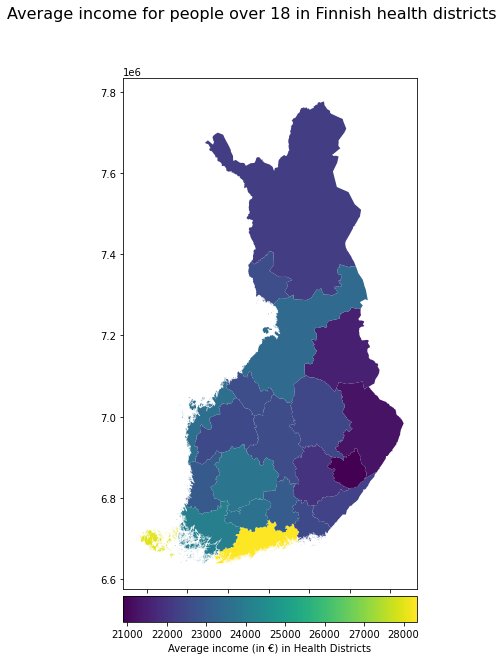

In [47]:
districts2 = districts2 [['healthCareDistrict', 'geometry', 'population', 'income_pro_person']]

fig,ax = plt.subplots(figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)   

fig.suptitle('Average income for people over 18 in Finnish health districts', fontsize=16)
districts2.plot( column='income_pro_person', ax=ax, cax = cax, legend=True, legend_kwds=
               {'label': "Average income (in €) in Health Districts", 'orientation': "horizontal"} ) 
